# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Explainability


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargement

In [4]:
import patat.util.file

filename = 'data/prod/230517-OIDS-Label.pickle'

df_label = patat.util.file.pickle_load(filename)

In [20]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

## Labels ou textes Nuls

In [6]:
df_label['text'].isna().sum()

0

In [7]:
df_label['infox'].isna().sum()

4

In [8]:
df_label = df_label[df_label['infox'].notna()]

In [9]:
df_label.reset_index(inplace=True)

## Données dupliquées

In [10]:
df_label.duplicated(subset='text').sum()

0

In [11]:
df_label.duplicated(subset='url').sum()

0

# Experience
---

## Equilibrage Dataset

<Axes: xlabel='infox', ylabel='count'>

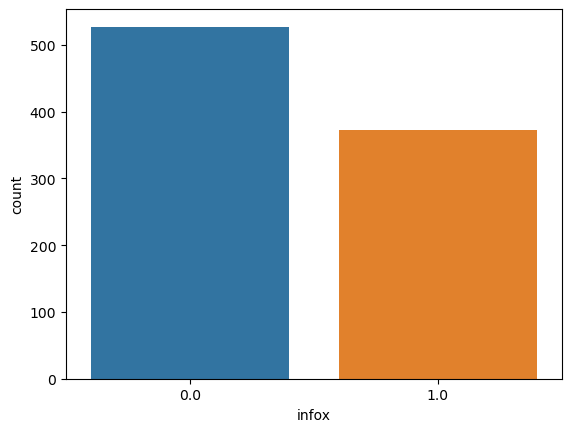

In [12]:
label_count = df_label['infox'].value_counts()
sns.barplot(x=label_count.index, y=label_count)

In [13]:
df_0 = df_label[df_label['infox'] == 0]
df_1 = df_label[df_label['infox'] == 1]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])[['text','infox']]

df_ml

,text,infox
609,Guerre en Ukraine: Emmanuel Macron prévient le...,0.0
705,La vaccination Covid : un marquage de « type b...,0.0
26,Colonialisme énergétique\nVisite d’État du pré...,0.0
565,De l’importance d’une Assemblée vraiment natio...,0.0
231,Quelle politique migratoire pour la France ? –...,0.0
...,...,...
112,Des scientifiques de Harvard et de Johns Hopki...,1.0
157,L’armée russe achète des exemplaires d’armemen...,1.0
522,ONU – Le Premier ministre de Nouvelle-Zélande ...,1.0
847,Pandémie ou le retour du grand Pan\nAu cours d...,1.0


In [14]:
print(df_ml['text'][15])

Selon le Pr Perronne l’apparition de la variole du singe n’est pas naturelle
La variole du singe est une maladie extrêmement rare et limitée à l’Afrique. Soudain, on nous annonce que des cas ont été enregistrés aux États-Unis, au Canada, au Royaume-Uni, en Australie, en Suède, aux Pays-Bas, en Belgique, en France, en Espagne, en Italie et en Allemagne, tous en même temps. Son nom est monkeypox ou variole du singe, et c’est la panique !
ttention à celui qui risque de faire perdre des milliards. Les milliards que les laboratoires encaissent grâce à l’interdiction des traitements contre le covid-19 et à l’obligation vaccinale pour avoir le droit de travailler et de se déplacer. Il a tenu « des propos considérés comme indignes de la fonction qu’il exerce ». Qui est ce pelé, ce galeux ? Le Pr Perronne, bien sûr !
Depuis que ses critiques sur la pseudo épidémie de covid ont été confirmées. Avec la variole du singe, le scénario catastrophe recommence et Perronne, ce complotiste invétéré, reco

In [282]:
patat.util.file.pickle_save(df_ml,'data/tmp/230603-df_ml.pickle')

# Experience
---

## Expérience de cross validation pour mesurer la performance des modeles


`scores = cross_validate(classifier, X, y, cv=5, scoring = metriques)`

- `classifier` : Classifier
- `X` : Features
- `y` : Label cible
- `cv` : Nombre de cycle d'entrainement/test
- `scoring` : Métriques





In [15]:
cv=5
y = df_ml['infox']

## Tfidf 
Features : `X_tfidf`

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [107]:
def tokenizer(t):
    return re.findall(r'[^\W\d][^\W\d]+',t)

In [194]:
#vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r'[^\W\d][^\W\d]+')
vectorizer = TfidfVectorizer(stop_words=stopwords)

In [195]:
X_tfidf = vectorizer.fit_transform(df_ml['text'])

## SKLearn Logistic Regression

In [229]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [230]:
logreg = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)

In [231]:
#svd = TruncatedSVD(n_components=500, n_iter=7, random_state=42)
#X = svd.fit_transform(X_tfidf)
X = X_tfidf

In [232]:
scores = cross_validate(logreg, X, y, cv=cv,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [233]:
df_scores=pd.DataFrame(scores)
#df_means = pd.DataFrame(df_scores.describe().loc[['mean','std']])
df_means = pd.DataFrame(df_scores.describe().loc['mean'])

pd.set_option('display.precision',4)
df_results = df_means
df_results

,mean
fit_time,0.2719
score_time,0.0022
test_accuracy,0.7708
test_f1,0.7627
test_recall,0.7370
test_roc_auc,0.8533


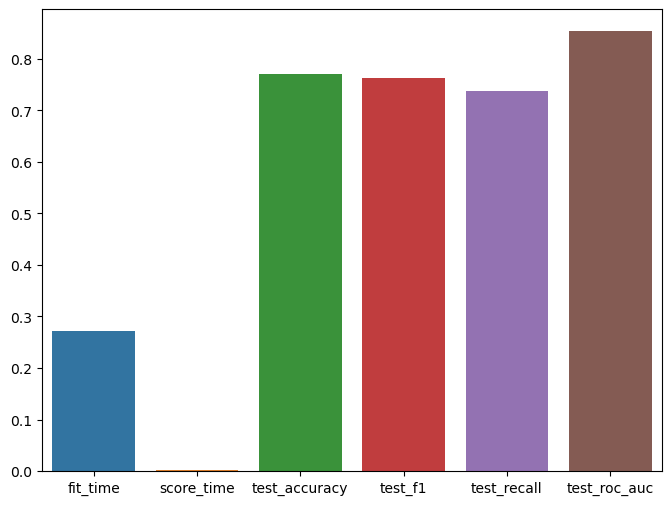

In [234]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.barplot(df_results.T)

<Figure size 800x600 with 0 Axes>

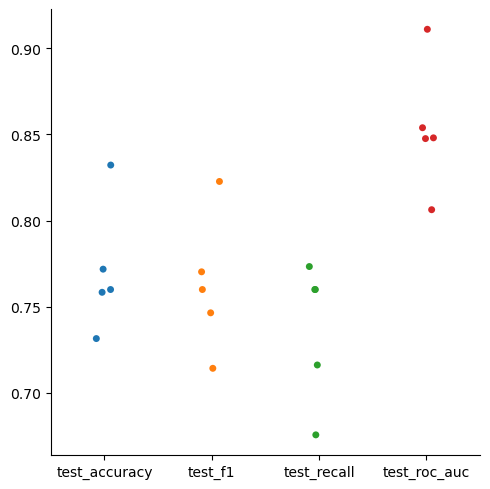

In [235]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

## SVC 

In [141]:
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, make_pipeline

In [142]:
from sklearn.model_selection import train_test_split
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X = svd.fit_transform(X_tfidf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_rs)


In [143]:
svc = SVC(C=150, gamma=2e-2, probability=True)

In [144]:
scores = cross_validate(svc, X, y, cv=cv,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [145]:
df_scores=pd.DataFrame(scores)
df_means = pd.DataFrame(df_scores.describe().loc[['mean','std']]).drop(columns=['fit_time','score_time'])

pd.set_option('display.precision',4)
df_results = df_means
df_results.T

,mean,std
test_accuracy,0.7413,0.0480
test_f1,0.7336,0.0455
test_recall,0.7104,0.0316
test_roc_auc,0.8296,0.0472


In [146]:
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,0.0956,0.0131,0.7600,0.7500,0.7200,0.8418
1,0.0602,0.0123,0.7383,0.7273,0.7027,0.8429
2,0.0581,0.0115,0.7047,0.6986,0.6892,0.7805
3,0.0581,0.0116,0.6913,0.6892,0.6800,0.7872
4,0.0595,0.0120,0.8121,0.8028,0.7600,0.8957


<Figure size 800x600 with 0 Axes>

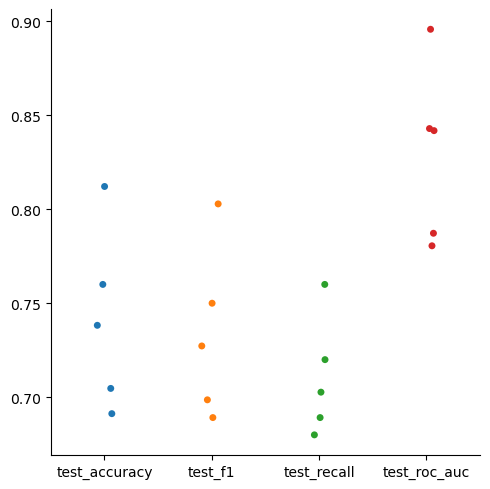

In [147]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

In [148]:
svc.fit(X,y)

SVC(C=150, gamma=0.02, probability=True)

# eli5 Text Explainer
---

## Entrainement pipeline sur l'ensemble du corpus

In [253]:
#logreg = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
logreg = LogisticRegression(C=150, random_state=_rs, max_iter=1000)

In [269]:
stopnums = [str(i) for i in range(0,2023)]
stopnums

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [275]:
#sw = stopwords+stopnums
sw = stopwords

In [276]:
#vectorizer = TfidfVectorizer(stop_words=stopwords+stopnums, token_pattern=r'[^\W\d][^\W\d]+')
vectorizer = TfidfVectorizer(stop_words=sw)

In [277]:
pipe = make_pipeline(vectorizer, logreg)
pipe.fit(df_ml['text'], df_ml['infox'])
pipe.score(df_ml['text'], df_ml['infox'])

1.0

In [278]:
import eli5
from eli5.lime import TextExplainer

In [281]:
eli5.format_as_dataframe(eli5.explain_weights(pipe, vec=vectorizer, top=1000,
                   feature_names=vectorizer.get_feature_names_out()))

ValueError: Can't figure out feature vector size for ['00' '000' '0000000000001294' ... '𝗨𝗸𝗿𝗮𝗶𝗻𝗲' '𝗱𝗶𝗿𝗲𝗰𝘁' '𝗲𝗻']

In [240]:
eli5.format_as_dict(eli5.show_weights(logreg, vec=vectorizer,
                   feature_names=vec.get_feature_names_out()))

NotAnAttrsClassError: <class 'IPython.core.display.HTML'> is not an attrs-decorated class.

In [236]:
text = df_ml.sample(1).iloc[0]['text']
print(f'Score infox : {pipe.predict_proba([text])[:,1]}\n{text}')

Score infox : [0.01655072]
Pour les féministes, Miss France est discriminatoire… et ça se règle aux prud’hommes !
Naguère, l'élection de Miss France était ce qu'on appelle un moment de télévision populaire. Les familles se mettaient devant la télé, un samedi soir de décembre, pour regarder défiler, venues de tout le pays, les jeunes filles réputées être les plus belles de France. Il y avait un peu de chauvinisme régional par-dessus tout ça, dans les discussions (« Miss Provence fait cagole », « Miss Pas-de-Calais est toute pâlote »...), d'autant plus que ces belles jeunes filles ne défilaient pas seulement en maillot de bain, contrairement à ce qu'un raccourci facile voudrait nous faire accroire. On les voyait aussi en costume régional - ces costumes venus d'une culture française qui n'existe pas. Il y avait des entretiens d'embauche avec le présentateur (moments parodiés par Helmut Fritz dans sa chanson « Miss France » : « Je suis actuellement... en BTS esthéticienne... dans le but de

In [237]:
eli5.show_prediction(clf, text,vec=vec,feature_names=vec.get_feature_names_out(),target_names=['non_infox','infox'])

# Exemple
---

In [97]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)
twenty_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    shuffle=True,
    random_state=42,
    remove=('headers', 'footers'),
)

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

vec = CountVectorizer()
clf = LogisticRegressionCV(max_iter=1000)
pipe = make_pipeline(vec, clf)

In [99]:
pipe.fit(twenty_train.data, twenty_train.target);

In [100]:
from sklearn import metrics

def print_report(pipe):
    y_test = twenty_test.target
    y_pred = pipe.predict(twenty_test.data)
    report = metrics.classification_report(y_test, y_pred,
        target_names=twenty_test.target_names)
    print(report)
    print("accuracy: {:0.3f}".format(metrics.accuracy_score(y_test, y_pred)))

print_report(pipe)

                        precision    recall  f1-score   support

           alt.atheism       0.81      0.76      0.79       319
         comp.graphics       0.82      0.93      0.87       389
               sci.med       0.87      0.78      0.82       396
soc.religion.christian       0.86      0.88      0.87       398

              accuracy                           0.84      1502
             macro avg       0.84      0.84      0.84      1502
          weighted avg       0.84      0.84      0.84      1502

accuracy: 0.840


In [ ]:
import eli5
eli5.show_weights(clf, top=10)

In [ ]:
eli5.show_weights(clf, vec=vec, top=10,
                  target_names=twenty_test.target_names)